In [1]:
import torch
import numpy as np
from train import create_dataloader
from model import make_model
from data_loader import CustomDataset

In [2]:
config = {'dataset': 'scada1_1', 'l_win': 200, 'pre_mask': 80, 'post_mask': 120,
          'batch_size': 64, 'shuffle': True, 'dataloader_num_workers': 10, 'num_epoch': 100, 'model_path': '../models/'}

In [3]:
model = make_model(N=6, d_model=16, l_win=config['l_win'], d_ff=128, h=1, dropout=0.1).float()
model.load_state_dict(torch.load(config['model_path'] + "best_train_46.pth"))
model.eval()

AnomalyModel(
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn): MultiHeadAttention(
          (linears): ModuleList(
            (0): Linear(in_features=16, out_features=16, bias=True)
            (1): Linear(in_features=16, out_features=16, bias=True)
            (2): Linear(in_features=16, out_features=16, bias=True)
            (3): Linear(in_features=16, out_features=16, bias=True)
          )
        )
        (feed_forward): PositionwiseFeedForward(
          (w_1): Linear(in_features=16, out_features=128, bias=True)
          (w_2): Linear(in_features=128, out_features=16, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (sublayer): ModuleList(
          (0): SublayerConnection(
            (norm): LayerNorm((16,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): SublayerConnection(
            (norm): LayerNorm((16,), eps=1e-05, elementwi

In [4]:
dataset = CustomDataset(config, train=False)
data_loader = create_dataloader(dataset, config)

In [5]:
out = None
batch = None
loss = torch.nn.MSELoss()
n_test = dataset.rolling_windows.shape[0]
recon_loss = np.zeros(n_test)
for i, batch in enumerate(data_loader):
    out = model(batch['input'].float(), src_mask=None)
    for j in range(config['batch_size']):
        try:
            recon_loss[i * config['batch_size'] + j] = loss(out[j, config['pre_mask']:config['post_mask'], :], batch['target'][j, :, :])
        except:
            pass    

In [6]:
idx_anomaly_test = dataset.data['idx_anomaly_test']
anomaly_index = []
test_labels = np.zeros(n_test)
for i in range(len(idx_anomaly_test)):
    idx_start = idx_anomaly_test[i] - (config['l_win'] + 1)
    idx_end = idx_anomaly_test[i] + (config['l_win'] + 1)
    if idx_start < 0:
        idx_start = 0
    if idx_end > n_test:
        idx_end = n_test
    anomaly_index.append(np.arange(idx_start, idx_end))
    test_labels[idx_start:idx_end] = 1

In [7]:
print(recon_loss.shape)
print(dataset.data['test'].shape)
print(dataset.rolling_windows.shape)
recon_loss

(68459,)
(68658, 16)
(68459, 200, 16)


array([0.68283845, 0.30998265, 0.32771299, ..., 0.65926728, 1.18009983,
       1.21999635])

In [8]:
def return_anomaly_idx_by_threshold(test_anomaly_metric, threshold):
    test_list = np.squeeze(np.ndarray.flatten(test_anomaly_metric))
    idx_error = np.squeeze(np.argwhere(test_anomaly_metric > threshold))
    
    if len(idx_error.shape) == 0:
        idx_error = np.expand_dims(idx_error, 0)
    
    return list(idx_error)

In [9]:
def augment_detected_idx(idx_detected_anomaly, anomaly_index):
    n_anomaly = len(anomaly_index)
    idx_detected_anomaly_extended = list(idx_detected_anomaly)
    for i in range(n_anomaly):
        #print(idx_detected_anomaly)
        for j in idx_detected_anomaly:
            if j in anomaly_index[i]:
                in_original_detection = set(idx_detected_anomaly_extended)
                currect_anomaly_win = set(anomaly_index[i])
                idx_detected_anomaly_extended = idx_detected_anomaly_extended + list(currect_anomaly_win - in_original_detection)
                #print(j)
                break
                
    return list(np.sort(idx_detected_anomaly_extended))

In [10]:
def count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels):
    n_TP = 0
    n_FP = 0
    #n_detection = len(idx_detected_anomaly)
    #for i in range(n_detection):
    for i in idx_detected_anomaly:    
        #if test_labels[idx_detected_anomaly[i]] == 1:
        if test_labels[i] == 1:    
            n_TP = n_TP + 1
        else:
            n_FP = n_FP + 1 #both branch the same?
    
    idx_undetected = list(set(np.arange(len(test_labels)))- set(idx_detected_anomaly))
    n_FN = 0
    for i in idx_undetected:
        if test_labels[i] == 1:
            n_FN = n_FN + 1
    n_TN = len(test_labels) - n_TP - n_FP - n_FN
    return n_TP, n_FP, n_FN, n_TN

In [11]:
def compute_precision_and_recall(idx_detected_anomaly, anomaly_index, test_labels):
    # compute true positive
    n_TP, n_FP, n_FN, n_TN = count_TP_FP_FN(idx_detected_anomaly, anomaly_index, test_labels)
    
    if n_TP + n_FP == 0:
        precision = 1
    else:
        precision = n_TP / (n_TP + n_FP)
    recall = n_TP / (n_TP + n_FN)
    if precision + recall == 0:
        F1 = 0
    else:
        F1 = 2* (precision * recall)/(precision + recall)
    fpr = n_FP/(n_FP + n_TN)    
    
    return precision, recall, F1, fpr, n_TP, n_FP, n_FN

In [12]:
import math
from scipy.stats import norm

def KQp(data,q):
#UNTITLED3 Summary of this function goes here
#   Detailed explanation goes here
    data2 = np.sort(data) #sap xep tang dan
    n = np.shape(data2)[0] #kich thuoc
    p = 1-q #q tu xet, dat bang smth 0.05 0.025 0.01
    h = math.sqrt((p*q)/(n+1));
    KQ=0;
    for i in range(1,n+1):
        a= ((i/n)-p)/h;
        b= (((i-1)/n)-p)/h;
        TP=(norm.cdf(a)-norm.cdf(b))*data2[i-1]; #normcdf thu trong matlab
        KQ=KQ+TP;    
    #KQp = KQ;
    return KQ

for i in [0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]:
    print("KQp is:", KQp(recon_loss,i),"with q =",i)


KQp is: 0.17111184663097667 with q = 0.99
KQp is: 0.1918394828901368 with q = 0.95
KQp is: 0.21226895236910726 with q = 0.9
KQp is: 0.22747718280898832 with q = 0.85
KQp is: 0.23707251267982782 with q = 0.8
KQp is: 0.2683924762476921 with q = 0.7
KQp is: 0.3041790412041757 with q = 0.6
KQp is: 0.3384558312839936 with q = 0.5
KQp is: 0.3699382888272649 with q = 0.4
KQp is: 0.40519595835045685 with q = 0.3
KQp is: 0.4831596854970711 with q = 0.2
KQp is: 0.9478404581498677 with q = 0.1


In [14]:
n_threshold = 25
precision = np.zeros(n_threshold)
recall = np.zeros(n_threshold)
F1 = np.zeros(n_threshold)
precision_aug = np.zeros(n_threshold)
recall_aug = np.zeros(n_threshold)
F1_aug = np.zeros(n_threshold)
fpr_aug = np.zeros(n_threshold)
i = 0
threshold_list = np.linspace(np.amin(recon_loss), np.amax(recon_loss), n_threshold, endpoint=True)
threshold_list = np.flip(threshold_list)
for threshold in threshold_list:
    #print(threshold_list[i])
    idx_detection = return_anomaly_idx_by_threshold(recon_loss, threshold)
    precision[i], recall[i], F1[i], _, _, _, _ = compute_precision_and_recall(idx_detection, 
                                                                           anomaly_index, 
                                                                           test_labels)
    # augment the detection using the ground truth labels
    # a method to discount the factor one anomaly appears in multiple consecutive windows
    # introduced in "Unsupervised anomaly detection via variational auto-encoder for seasonal kpis in web applications"
    idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index)
    precision_aug[i], recall_aug[i], F1_aug[i], fpr_aug[i], _, _, _ = compute_precision_and_recall(idx_detection_augmented, 
                                                                                       anomaly_index, 
                                                                                       test_labels)
    i = i + 1
    #print(precision, recall, F1)    
    
print('threshold list:',threshold_list)

threshold list: [4.29628816e+02 4.11733786e+02 3.93838755e+02 3.75943724e+02
 3.58048693e+02 3.40153662e+02 3.22258631e+02 3.04363600e+02
 2.86468570e+02 2.68573539e+02 2.50678508e+02 2.32783477e+02
 2.14888446e+02 1.96993415e+02 1.79098384e+02 1.61203353e+02
 1.43308323e+02 1.25413292e+02 1.07518261e+02 8.96232299e+01
 7.17281990e+01 5.38331682e+01 3.59381373e+01 1.80431064e+01
 1.48075540e-01]


In [15]:
print("Best F1 score is {}".format(np.amax(F1)))
idx_best_threshold = np.squeeze(np.argwhere(F1 == np.amax(F1)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
print("At this threshold, precision is {}, recall is {}".format(precision[idx_best_threshold], recall[idx_best_threshold]))
average_precision = np.sum(precision[1:] * (recall[1:] - recall[:-1]))
print("Average precision is {}".format(average_precision))

print("\nAugmented detection:")
print("Best F1 score is {}".format(np.amax(F1_aug)))
idx_best_threshold = np.squeeze(np.argwhere(F1_aug == np.amax(F1_aug)))
print("Best threshold is {}".format(threshold_list[idx_best_threshold]))
best_thres = np.min(threshold_list[idx_best_threshold])
print("At this threshold, precision is {}, recall is {}".format(precision_aug[idx_best_threshold], 
                                                                recall_aug[idx_best_threshold]))

average_precision_aug = np.sum(precision_aug[1:] * (recall_aug[1:] - recall_aug[:-1]))
print("Average precision is {}".format(average_precision_aug))

Best F1 score is 0.9846719712868276
Best threshold is 0.14807553982824487
At this threshold, precision is 0.9698209120920857, recall is 0.9999849381711927
Average precision is 0.96977267001817

Augmented detection:
Best F1 score is 0.9846795004894254
Best threshold is 0.14807553982824487
At this threshold, precision is 0.9698213529265692, recall is 1.0
Average precision is 0.9940677475981843


In [16]:
# Now select a threshold
threshold = best_thres
q_list = [0.99, 0.95, 0.9, 0.85, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
temp = math.inf
q_best = 0
closest_thres = 0
for q in q_list:
    temp_thres = KQp(recon_loss, q)
    #print(temp_thres,abs(temp_thres - threshold))
    if abs(temp_thres - threshold) < temp:
        temp = abs(temp_thres - threshold)
        q_best = q
        KQp_thres = temp_thres
    
print("Closest KQp threshold is {} at q = {}".format(KQp_thres,q_best))
idx_detection = return_anomaly_idx_by_threshold(recon_loss, KQp_thres)
#print(idx_detection)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index)
#print(anomaly_index_lstm)
#print(idx_detection_augmented)
precision, recall, F1, _, n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index, 
                                                                       test_labels)
print("\nPR evaluation using KQE:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))
print("FN: {}".format(n_FN))

print("\nThreshold is {}".format(threshold))
idx_detection = return_anomaly_idx_by_threshold(recon_loss, threshold)
idx_detection_augmented = augment_detected_idx(idx_detection, anomaly_index)
precision, recall, F1, _,n_TP, n_FP, n_FN = compute_precision_and_recall(idx_detection_augmented, 
                                                                       anomaly_index, 
                                                                       test_labels)
print("\nPR evaluation using augmented detection:")
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1: {}".format(F1))
print("TP: {}".format(n_TP))
print("FP: {}".format(n_FP))

Closest KQp threshold is 0.17111184663097667 at q = 0.99

PR evaluation using KQE:
Precision: 0.9701614670855556
Recall: 1.0
F1: 0.9848547779393004
TP: 66393
FP: 2042
FN: 0

Threshold is 0.14807553982824487

PR evaluation using augmented detection:
Precision: 0.9698213529265692
Recall: 1.0
F1: 0.9846795004894254
TP: 66393
FP: 2066


AUC = 0.5069441081778163


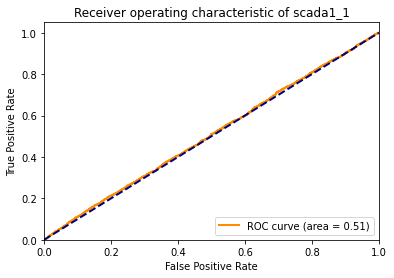

In [17]:
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
fpr, tpr, _ = metrics.roc_curve(test_labels,recon_loss, pos_label = 1)
auc = metrics.auc(fpr,tpr)
print('AUC =', auc)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic of ' + config['dataset'])
plt.legend(loc="lower right")
plt.show()

AUC = 0.9017489896217584


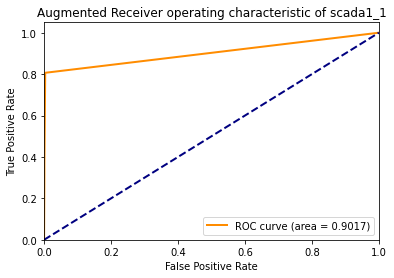

In [19]:
tpr = np.insert(recall_aug,[0,n_threshold],[0,1])
fpr = np.insert(fpr_aug,[0,n_threshold],[0,1])
auc = metrics.auc(fpr,tpr)
print('AUC =', auc)
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.4f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Augmented Receiver operating characteristic of ' + config['dataset'])
plt.legend(loc="lower right")
# savefig(config['result_dir']+ 'augmentedroc.pdf')
plt.show()